Started
0.0005123615264892578
0.015845298767089844
0.016572952270507812
0.016777515411376953
0.01613306999206543
0.01654815673828125
0.016619205474853516
0.016744375228881836
0.017029762268066406
0.017015457153320312
0.016264677047729492
0.016465425491333008
0.016788244247436523
0.0168001651763916
0.016672849655151367
0.016590356826782227
0.016727685928344727
0.016326904296875
0.017023086547851562
0.016423463821411133
0.017009258270263672
0.016667842864990234
0.01712942123413086
0.0164339542388916
0.016603708267211914
0.01683831214904785
0.016254663467407227
0.016857624053955078
0.016550779342651367
0.016307830810546875
0.016758441925048828
0.016736984252929688
0.017002105712890625
0.01678776741027832
0.01642584800720215
0.01708531379699707
0.016428470611572266
0.017321348190307617
0.015947341918945312
0.016520261764526367
0.016548871994018555
0.017035245895385742
0.016415119171142578
0.016648530960083008
0.016777753829956055
0.016506195068359375
0.016991138458251953
0.0164899826049804

0.01611495018005371
0.016445636749267578
0.01648426055908203
0.01691603660583496
0.016727924346923828
0.01678752899169922
0.016622543334960938
0.016577482223510742
0.01680731773376465
0.01653909683227539
0.01680445671081543
0.0166013240814209
0.01667046546936035
0.01691603660583496
0.016634702682495117
0.01667308807373047
0.01658797264099121
0.016615629196166992
0.016789913177490234
0.016695261001586914
0.016875267028808594
0.016663074493408203
0.016676664352416992
0.016610145568847656
0.016686677932739258
0.01649022102355957
0.016979217529296875
0.01663947105407715
0.016794204711914062
0.016833066940307617
0.01660323143005371
0.016489028930664062
0.01692676544189453
0.016797542572021484
0.016149044036865234
0.017077207565307617
0.016515254974365234
0.016889572143554688
0.016522645950317383
0.01654338836669922
0.016964197158813477
0.016609668731689453
0.016475200653076172
0.01689600944519043
0.016770124435424805
0.016250133514404297
0.016736984252929688
0.01650714874267578
0.0166795253

0.016849994659423828
0.016585111618041992
0.016658782958984375
0.01667308807373047
0.01711726188659668
0.01675868034362793
0.016302824020385742
0.016837358474731445
0.01682734489440918
0.01666259765625
0.016527414321899414
0.016936540603637695
0.01693558692932129
0.016370534896850586
0.016367673873901367
0.016818523406982422
0.01668262481689453
0.01673412322998047
0.016431093215942383
0.01680588722229004
0.01697397232055664
0.016257524490356445
0.016566753387451172
0.01674032211303711
0.016665935516357422
0.016834497451782227
0.016611337661743164
0.016743898391723633
0.01672506332397461
0.016631126403808594
0.016928434371948242
0.01638007164001465
0.016948223114013672
0.016357421875
0.016839981079101562
0.016779184341430664
0.016304969787597656
0.016904830932617188
0.01650834083557129
0.016699790954589844
0.016681909561157227
0.01665949821472168
0.016722440719604492
0.01632547378540039
0.016719341278076172
0.01670384407043457
0.016826152801513672
0.01697254180908203
0.01645064353942871

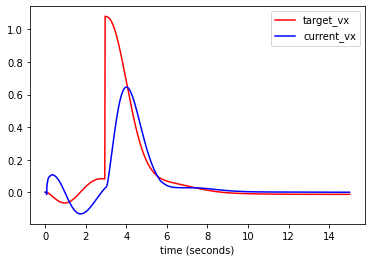

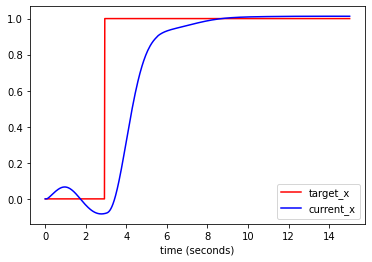

Done


In [4]:
import sys
sys.path.append("../../")

import math
import time

from lib.data.dataplot import *
from lib.dds.dds import *
from lib.utils.time import *
from lib.system.controllers import *


class Multirotor:

    def __init__(self):
        self.vz_control = PID_Controller(5.0, 10.0, 0.0, 5)
        self.z_control = PID_Controller(2.0, 0.0, 0.0, 2)  # 2 m/s
        
        self.w_roll_control = PID_Controller(0.75, 0.3, 0.0075, 2)
        self.roll_control = PID_Controller(1.0, 0.0, 0.0, 2) # max 2 rad/s

        self.w_pitch_control = PID_Controller(0.75, 0.3, 0.0075, 2)
        self.pitch_control = PID_Controller(1.0, 0.0, 0.0, 2) # max 2 rad/s
        
        self.vy_control = PID_Controller(0.4, 0.01, 0.25, math.radians(30))
        self.y_control = PID_Controller(1.0, 0.0, 0.0, 2.0)

        self.vx_control = PID_Controller(0.4, 0.01, 0.25, math.radians(30))
        self.x_control = PID_Controller(1.0, 0.0, 0.0, 2.0)
        
        self.z_target = 1.0
        self.x_target = 0.0
        self.y_target = 0.0

    def evaluate(self, delta_t, z, vz, x, vx, y, vy, roll, roll_rate, pitch, pitch_rate):
        # propeller order
        #
        #  3     4
        #
        #  2     1
        #
        
        # altitude control
        self.vz_target = self.z_control.evaluate(delta_t, self.z_target - z)
        f = self.vz_control.evaluate(delta_t, self.vz_target - vz)
        
        self.vy_target = self.y_control.evaluate(delta_t, self.y_target - y)
        self.roll_target = - self.vy_control.evaluate(delta_t, self.vy_target - vy)
        
        self.vx_target = self.x_control.evaluate(delta_t, self.x_target - x)
        self.pitch_target = self.vx_control.evaluate(delta_t, self.vx_target - vx)
        
        # roll control
        self.roll_rate_target = self.roll_control.evaluate(delta_t, self.roll_target - roll)
        roll_command = self.w_roll_control.evaluate(delta_t, self.roll_rate_target - roll_rate)
        
        # pitch control
        self.pitch_rate_target = self.pitch_control.evaluate(delta_t, self.pitch_target - pitch)
        pitch_command = self.w_pitch_control.evaluate(delta_t, self.pitch_rate_target - pitch_rate)
        
        
        return f + roll_command - pitch_command, f - roll_command - pitch_command, \
                f - roll_command + pitch_command, f + roll_command + pitch_command

    
dpvz = DataPlotter()
dpvz.set_x("time (seconds)")
dpvz.add_y("target_vx", "target_vx")
dpvz.add_y("current_vx", "current_vx")

dpz = DataPlotter()
dpz.set_x("time (seconds)")
dpz.add_y("target_x", "target_x")
dpz.add_y("current_x", "current_x")

dds = DDS()
dds.start()

dds.subscribe(['start','tick', 'X', 'Y', 'Z', 'TX', 'TY', 'TZ', 'VX', 'VY', 'VZ', 'WX', 'WY', 'WZ'])

robot = Multirotor()

dds.wait('start')
print("Started")

t = Time()
t.start()
while t.get() < 15:
    
    dds.wait('tick')    
    delta_t = t.elapsed()
    
    z = dds.read('Z')
    vz = dds.read('VZ')
    
    x = dds.read('X')
    vx = dds.read('VX')
    
    y = dds.read('Y')
    vy = dds.read('VY')
    
    roll = dds.read('TX')
    roll_rate = dds.read('WX')
    
    pitch = dds.read('TY')
    pitch_rate = dds.read('WY')
    
    (f1, f2, f3, f4) = robot.evaluate(delta_t, z, vz, x, vx, y, vy, roll, roll_rate, pitch, pitch_rate)

    if abs(z - 1.0) < 0.01:
        robot.x_target = 1.0
        robot.y_target = 1.0
        save_data = True

    dds.publish('f1', f1, DDS.DDS_TYPE_FLOAT)
    dds.publish('f2', f2, DDS.DDS_TYPE_FLOAT)
    dds.publish('f3', f3, DDS.DDS_TYPE_FLOAT)
    dds.publish('f4', f4, DDS.DDS_TYPE_FLOAT)
    
    dpvz.append_x(t.get())
    dpvz.append_y("target_vx", robot.vx_target)
    dpvz.append_y("current_vx", vx)

    dpz.append_x(t.get())
    dpz.append_y("target_x", robot.x_target)
    dpz.append_y("current_x", x)


dds.publish('f1', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f2', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f3', 0, DDS.DDS_TYPE_FLOAT)
dds.publish('f4', 0, DDS.DDS_TYPE_FLOAT)
    

dds.stop()
dpvz.plot()
dpz.plot()

print("Done")